In [397]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs={'dpi' : 90}
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%load_ext autoreload
%autoreload 2

import os
from urllib.request import urlopen
from io import StringIO,BytesIO
from astropy.io import ascii
from astropy.io import fits as pyfits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table,Column
from astropy.io.misc import yaml
import matplotlib.cm as cm
import numpy as np
import scipy.interpolate as sinterp
import scipy.integrate as sint
import scipy.optimize as sop
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter

mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('axes',facecolor = (1,1,1,1))
mpl.rc('figure',facecolor = 'w')
mpl.rc('text', usetex=True)
mpl.rc('figure',figsize=(4.2,2.4))
mpl.rc('figure',dpi=320)
mpl.rc('savefig',dpi=320)
mpl.rc('axes',unicode_minus = False)
mpl.rcParams['axes.unicode_minus'] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
class Eblmodel(object):
    def load_ebl_dominguez(self):
        # Load EBL table from Dominguez et al. 2011:
        eblmodeltab = Table.read(
            "https://raw.githubusercontent.com/me-manu/ebltable/"+\
            "master/ebltable/data/tau_dominguez11_cta.out",
            format='ascii')
        eblstruc = eblmodeltab.as_array()
        eblarray = eblstruc.view(np.float64).reshape(eblstruc.shape + (-1,))

        self.eblmodel = dict()
        self.eblmodel['redshifts'] = eblarray[0][1:]
        self.eblmodel['energies'] = np.log10(eblarray[:, 0][1:])
        self.eblmodel['tau2d'] = eblarray[1:, 1:]
        self.eblmodel['E0']  = 0.1 # 100 GeV
    
    def set_interpolator(self):
        self.ebl_tau_interp = sinterp.RectBivariateSpline(
            self.eblmodel['redshifts'], 
            self.eblmodel['energies'], 
            self.eblmodel['tau2d']
        )
    
    def ebl_absorption(z,E): 
        return np.exp(-self.ebl_tau_interp(z, np.log10(E)))

class Spectra(object):
    def __init__(self):
        self.redshift = 1
    
    def set_redshift(self,z):
        self.redshift = z
    
    def set_type(self,sptype):
        if sptype in ['EHSP','EHBL']:
            self.Ecutoff = 10
        elif sptype in ['HSP','HBL']:
            self.Ecutoff = 11
        else:
            self.Ecutoff = 0.1
        
        self.Ecutoff *= 1./(1+self.redshift)
        
    def powerlaw(self, E, theta):
        N0, Gamma = theta
        sed = E**2 * N0 * (E/E0)**Gamma
        return(sed)
    def logparabola(self, E, theta):
        beta = theta[-1]
        sed = self.powerlaw(E,theta[:-1])*(E/E0)**(-beta*np.log10(E/E0))
        return(sed)
    def pwl_supexpcutoff(self, E, theta):
        Ecutoff,Gamma2 = theta[-2],theta[-1]
        sed = self.powerlaw(E,theta[:-2])*np.exp(-(E/Ecut)**Gamma2)
    def logparabola_cutoff(self,E,theta):
        Ecutoff = theta[-1]
        sed = logparabola(E,theta[:-1])*np.exp(-(E/Ecut)**Gamma2)
    def logparabola_ctacut(self,E,theta)
        sed = logparabola(E,theta)*np.exp(-(E/self.Ecut))
    
    @staticmethod
    def lat_model_interpreter(E,model):
        PivotE = model['PivotE']
        Fnorm = model['Fnorm']
        EFnorm = model['EFnorm']
        Gamma = model['Gamma']
        EGamma = model['EGamma']
        if 'Beta' in model:
            Beta = model['Beta']
            EBeta = model['EBeta']
        else:
            Beta = 0
            EBeta = 0
        if 'ExpF' in model:
            ExpF = model['ExpF']
            EExpF = model['EExpF']
            ExpI = model['ExpI']
            EExpI = model['EExpI']
        else:
            ExpF = 0
            EExpF = 0
            ExpI = 0
            EExpI = 0
    
        sed = (1.60218 * 1e-6) * Fnorm * (e ** 2) * \
              ((e / PivotE) ** (-Gamma - Beta * np.log(e / PivotE)))*\
              np.exp(ExpF * (PivotE ** ExpI - e ** ExpI))
        
        return(sed)
        

In [270]:
class Residuals(object):
    def __init__(self):
        # dict with log of values of X and Y-residues for different type of sources.
        self.xlogval = {}
        self.ylogval = {}
        self.ylogmod = {}
        self.ylogres = {}
        self.ylogerr = {}

    def reset_cls(self,cls):
        self.xlogval[cls] = {}
        self.ylogval[cls] = {}
        self.ylogmod[cls] = {}
        self.ylogres[cls] = {}
        self.ylogerr[cls] = {}

    def reset_cls_model(self,cls,model):
        if cls not in self.xlogval:
            self.reset_cls(cls)

        self.xlogval[cls][model] = []
        self.ylogval[cls][model] = []
        self.ylogmod[cls][model] = []
        self.ylogres[cls][model] = []
        self.ylogerr[cls][model] = []

    def add_value(self, point):
        cls = point['srccls']
        model = point['model']
        xlogval = point['xlogval']
        ylogval = point['ylogval']
        ylogerr = point['ylogerr']
        ylogmod = point['ylogmod']
        # ylogres = point['ylogres']

        if cls not in self.xlogval:
            self.reset_cls(cls)

        if model not in self.xlogval[cls]:
            self.reset_cls_model(cls,model)

        self.xlogval[cls][model].append(xlogval)
        self.ylogval[cls][model].append(ylogval)
        self.ylogmod[cls][model].append(ylogmod)
        self.ylogres[cls][model].append((ylogval -ylogmod ) /ylogerr)


In [316]:
class Catalog(object):
    def reset_spectral_points(self):
        self.xval = []
        self.xerrn = []
        self.xerrp = []
        self.yval = []
        self.yerrn = []
        self.yerrp = []
        #self.residuals = Residuals()
        #self.spectra   = Spectra()
    
    #@staticmethod
    def match_src_catalog(self, catalog, src, tol=0.5*u.Unit("deg")):
        coord_catalog = SkyCoord(
            ra=catalog['ra'] * u.Unit("deg"),
            dec=catalog['dec'] * u.Unit("deg")
        )

        c = SkyCoord(
            ra=src['ra'] * u.Unit("deg"),
            dec=src['dec'] * u.Unit("deg")
        )

        idx, d2d, d3d = c.match_to_catalog_3d(coord_catalog)
        #print(idx, d2d, d3d)
        if d2d > tol:
            return None

        return catalog['id'][idx]
    
    def reset_results(self):
        self.result = dict()
  

In [486]:
class GammaCAT(Catalog):
    def read(self,f):
        with open(f) as temp:
            self.contents = yaml.load(temp.read())
            #return(self.contents)
    
    def build(self,f,ind,outf="gammacat_export.yaml"):
        
        os.chdir(ind)
        with open("gammacat.yaml") as gammacat:
            temp = yaml.load(gammacat.read())
            gammacat = dict()
            for k,source_id in enumerate(temp):
                gammacat[source_id[0][1]] = dict()
                for pair in temp[k]:
                    gammacat[source_id[0][1]][pair[0]] = pair[1]
        
        with open("gammacat-datasets.json") as datasets:
            temp = json.load(datasets)
            datasets = dict()
            for item in temp:
                if item['source_id'] not in datasets:
                    datasets[item['source_id']] = dict()
                
                # copy identifiers from gammacat
                if item['source_id'] in gammacat:
                    print('Appending data from gammacat[{0}]'.format(item['source_id']))
                    for tocopy in gammacat[item['source_id']]:
                        datasets[item['source_id']][tocopy] = gammacat[item['source_id']][tocopy]
                else:
                    print('Fallback, getting the info from the sources dir')
                    info = read_yaml("sources/tev-{0:06d}.yaml".format(item['source_id']))
                    for tocopy in info:
                        datasets[item['source_id']][tocopy] = info[tocopy]

                if item['type'] == 'sed':
                    try:
                        content = open(item['location']).read() #Table.read(item['location'])
                    except:
                        print('Skipping {0}'.format(item['location']))

                    if 'sed' in datasets[item['source_id']]:
                        datasets[item['source_id']]['sed'].append(content)
                    else:
                        datasets[item['source_id']]['sed'] = [content]
                    
                    
        with open("gammacat_export_20210215.yaml","w+") as gcf:
            yaml.dump(datasets,gcf)
            
        self.contents = datasets
        
    def match_src(self,src,tol=0.5*u.Unit("deg")):
        list_items = self.contents.keys()
        catalog = {}
        catalog['dec'] = [self.contents[item]['dec'] \
                          for item in self.contents \
                          if 'dec' in self.contents[item]]
        catalog['ra']  = [self.contents[item]['ra'] \
                          for item in self.contents \
                          if 'dec' in self.contents[item]]
        catalog['id']  = [item for item in self.contents \
                          if 'dec' in self.contents[item]]
        
        self.matched = self.contents[self.match_src_catalog(catalog,src,tol)]
        
    def get_spectralpoints(self):
        self.results = []
        for k, sed in enumerate(self.matched['sed']):
            energyerr = None
            # replace ECSV dump by its Table version
            sed = Table.read(sed, format='ascii.ecsv')
            #print(sed)
            energies = sed['e_ref'].to("TeV")
            flux = sed['dnde']
            if 'dnde_err' in sed.keys():
                fluxerr = sed['dnde_err']
                logFlux = 2 * np.log10(flux) - np.log10(flux + fluxerr)
                fluxerr = [flux - (10**(logFlux)), fluxerr]
            elif 'dnde_errp' in sed.keys():
                fluxerr = [sed['dnde_errn'], sed['dnde_errp']]
            else:
                print('No dnde_err*, check' )
                print(sed)
            
    
            isnotnan = ~np.isnan(flux) * (flux > 0)
            energies = energies[isnotnan]
            flux = flux[isnotnan]
            fluxerr = np.asarray([fluxerr[0][isnotnan], fluxerr[1][isnotnan]])
            
            # add units
            fluxerr = fluxerr*flux.unit
            
            
            if 'e_min' in sed.keys() and 'e_max' in sed.keys():
                energyerrn = (energies - sed['e_min'][isnotnan]).to(energies.unit)
                energyerrp = (sed['e_max'][isnotnan] - energies).to(energies.unit)

            if energyerr is None:
                energylog = np.log10(energies.value)
                energylogsep = np.min(energylog[1:] - energylog[:-1])
                energyerrn = energies.value - (10 ** (energylog - energylogsep / 2.))
                energyerrp = 10 ** (energylog + energylogsep / 2.) - energies.value

            e2flux = energies ** 2 * flux
            e2fluxerr = energies ** 2 * fluxerr

            result = {}
            result['name'] = self.matched['common_name']
            result['set'] = k
            result['E'] = energies.to("TeV")
            result['Eerr'] = np.asarray([energyerrn, energyerrp]) * energies.unit
            result['Eerr'] = result['Eerr'].to("TeV")
            result['EF'] = e2flux.to("erg/(cm2*s)")
            result['EFerr'] = e2fluxerr.to("erg/(cm2*s)")
            self.results.append(result)

In [562]:
class FermiCAT(Catalog):
    def __init__(self):
        pass
        
    def set_catalog_urls(self):
        baseurl = "https://fermi.gsfc.nasa.gov/ssc/data/access/lat"
        self.fhl3 = pyfits.open(baseurl+"/3FHL/gll_psch_v13.fit")
        self.fgl4 = pyfits.open(baseurl+"/10yr_catalog/gll_psc_v26.fit")
        self.lac4 = pyfits.open(baseurl+"/4LACDR2/table-4LAC-DR2-h.fits")
        self.lac4_low = pyfits.open(baseurl+"/4LACDR2/table-4LAC-DR2-l.fits")
    
    def set_active_catalog(self,cat):
        self.cat_name = cat
        if cat=='4LAC':
            self.get_spectralpoints_4fgl()
            import numpy.lib.recfunctions
            concat = numpy.lib.recfunctions.stack_arrays(\
                (lac4[1].data,lac4_low[1].data), 
                autoconvert=True, usemask=False)

            self.cat = concat
        elif cat=='4FGL':
            self.get_spectralpoints_4fgl()
            self.cat = self.fgl4[1].data
        elif cat=='3FHL':
            self.get_spectralpoints_3fhl()
            self.cat = self.fhl3[1].data
    
    def get_spectralpoints_3fhl(self):
        self.raw_energies = self.fhl3[4].data
    
    def get_spectralpoints_4fgl(self):
        self.raw_energies = np.asarray([50, 100, 300, 1e3, 3e3, 1e4, 3e4, 3e5])*1e-3
        self.raw_energies = np.transpose([self.raw_energies[:-1], 
                                          self.raw_energies[1:], 
                                          0*self.raw_energies[1:]])
    
    def match_src(self,src,tol=0.5*u.Unit("deg")):
        catalog = dict()
        catalog['dec'] = self.cat['DEJ2000']
        catalog['ra']  = self.cat['RAJ2000']
        catalog['id']  = np.arange(len(catalog['ra']))
        self.matched = self.cat[self.match_src_catalog(catalog,src,tol)]
          
    def extract_model_parameters(self):
        # Get model parameters from 4FGL/4LAC:
        self.result['pwl'] = dict()
        self.result['lp'] = dict()
        self.result['plec'] = dict()
        # Powerlaw
        self.result['pwl']['PivotE'] = self.matched['Pivot_Energy']
        self.result['pwl']['Fnorm'] = self.matched['PL_Flux_Density']
        self.result['pwl']['EFnorm'] = self.matched['Unc_PL_Flux_Density']
        self.result['pwl']['Gamma'] = self.matched['PL_Index']
        self.result['pwl']['EGamma'] = self.matched['Unc_PL_Index']
        # LogParabola
        self.result['lp']['PivotE'] = self.matched['Pivot_Energy']
        self.result['lp']['Fnorm'] = self.matched['LP_Flux_Density']
        self.result['lp']['EFnorm'] = self.matched['Unc_LP_Flux_Density']
        self.result['lp']['Gamma'] = self.matched['LP_Index']
        self.result['lp']['EGamma'] = self.matched['Unc_LP_Index']
        self.result['lp']['Beta'] = self.matched['LP_beta']
        self.result['lp']['EBeta'] = self.matched['Unc_LP_beta']
        # Powerlaw with exponential cutoff
        self.result['plec']['PivotE'] = self.matched['Pivot_Energy']
        self.result['plec']['Fnorm'] = self.matched['PLEC_Flux_Density']
        self.result['plec']['EFnorm'] = self.matched['Unc_PLEC_Flux_Density']
        self.result['plec']['Gamma'] = self.matched['PLEC_Index']
        self.result['plec']['EGamma'] = self.matched['Unc_PLEC_Index']
        self.result['plec']['ExpF'] = self.matched['PLEC_Expfactor']
        self.result['plec']['EExpF'] = self.matched['Unc_PLEC_Expfactor']
        self.result['plec']['ExpI'] = self.matched['PLEC_Exp_Index']
        self.result['plec']['EExpI'] = self.matched['Unc_PLEC_Exp_Index']
    
    def fill_spectrum(self):
        Eraw = self.raw_energies
        E = np.asarray([10 ** np.mean(np.log10(k[:-1])) for k in Eraw])
        Eerrn = np.asarray([E[k] - re[0] for k, re in enumerate(Eraw)])
        Eerrp = np.asarray([re[1] - E[k] for k, re in enumerate(Eraw)])
        
        F      = self.matched['Flux_Band']* u.Unit("cm**-2 * s**-1")
        Ferr   = np.transpose(np.abs(self.matched['Unc_Flux_Band']))*u.Unit("cm**-2 * s**-1")
        E      = E * u.Unit("GeV")
        SED    = (F * E).to("erg/(cm2*s)")
        SEDerr = (Ferr * E).to("erg/(cm2*s)")
        
        isnotnan = (~np.isnan(F))*\
                   (~np.isnan(Ferr[0])) * (F > 0)
        
        
        self.result['name'] = self.matched['Source_Name']
        self.result['E'] = E[isnotnan].to("TeV")
        Eerr = np.asarray([Eerrn[isnotnan],Eerrp[isnotnan]])*u.Unit("GeV")
        self.result['Eerr'] = Eerr.to("TeV")
        self.result['EF'] = SED[isnotnan]
        self.result['EFerr'] = np.asarray(
            [SEDerr[0][isnotnan],SEDerr[1][isnotnan]])
        self.result['EFerr'] = self.result['EFerr']*SED.unit
        #return(self.result)
    
    def extract_redshift(self):
        # Get parameters + redshift
        self.result['redshift'] = 0
        if '3FHL' in self.result['name']:
            try:
                self.result['redshift'] = self.matched['REDSHIFT']
            except:
                pass
        elif '4FGL' in self.result['name']: # 
            srcnamefilt = self.lac4[1].data['Source_Name'] == self.result['name']
            self.redshift = 0 
            if np.sum(srcnamefilt) == 0:
                srcnamefilt = self.lac4_low[1].data['Source_Name'] == self.result['name']
                if np.sum(srcnamefilt) == 1:
                    self.redshift = self.lac4_low[1].data[srcnamefilt]['Redshift']
            else:
                self.redshift = self.lac4[1].data[srcnamefilt]['Redshift']
        
        self.result['redshift'] = self.redshift.flat[0]
    
    
        
        



In [563]:
baseurl = "https://fermi.gsfc.nasa.gov/ssc/data/access/lat"
lac4 = pyfits.open(baseurl+"/4LACDR2/table-4LAC-DR2-h.fits")
lac4_low = pyfits.open(baseurl+"/4LACDR2/table-4LAC-DR2-l.fits")

In [564]:
src = gammacat.contents[8]

In [565]:
gammacat = GammaCAT()
gammacat.read("../ext2TeV/data/gammacat_export_20210215.yaml")
gammacat.reset_results()
gammacat.match_src(src)
gammacat.get_spectralpoints()

In [566]:
fermicat = FermiCAT()
fermicat.set_catalog_urls()
fermicat.set_active_catalog("4FGL")
fermicat.reset_spectral_points()
fermicat.reset_results()
fermicat.match_src(src)
fermicat.fill_spectrum()
fermicat.extract_redshift()

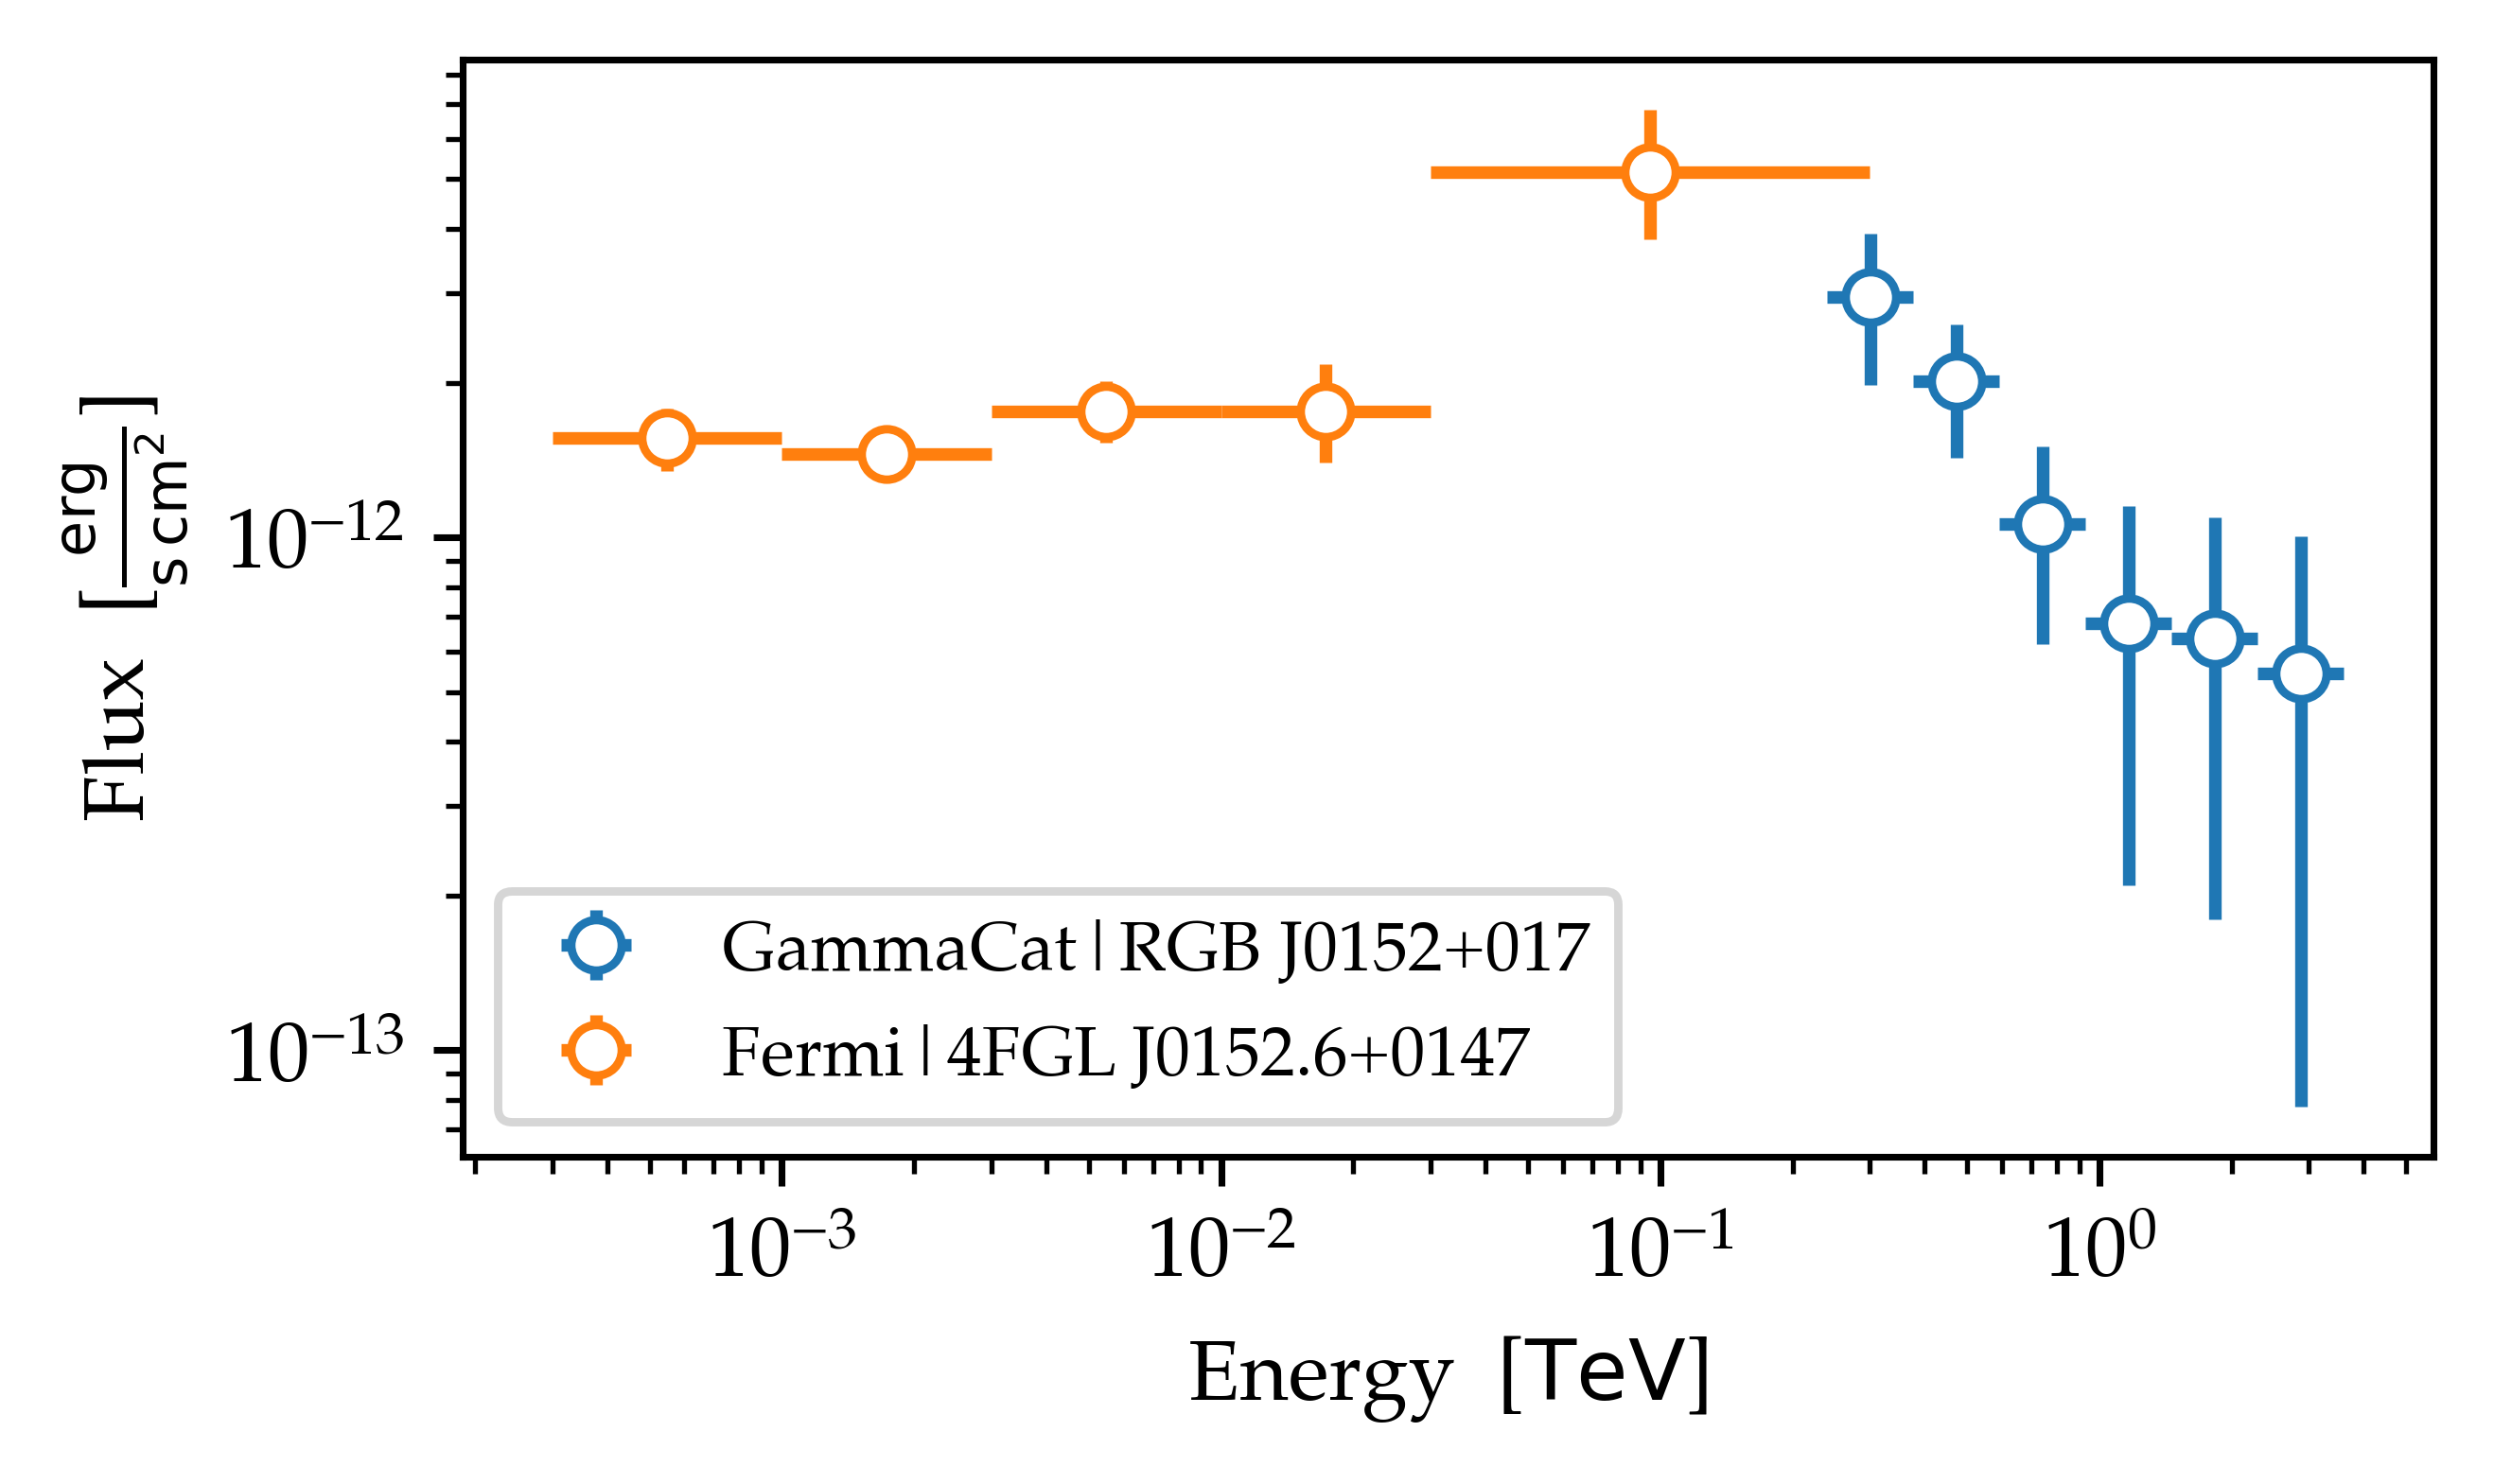

In [567]:
xunit = gammacat.results[0]['E'].unit
yunit = gammacat.results[0]['EF'].unit 
mpl.rcParams['text.usetex'] = False

for spec in gammacat.results:
    plt.errorbar(
        x=spec['E']/xunit,
        xerr=spec['Eerr']/xunit,
        y=spec['EF']/yunit,
        yerr=spec['EFerr']/yunit,
        ls='None',
        marker='o',
        mfc='white',
        label='GammaCat|{}'.format(spec['name'])
    )

plt.errorbar(
    x=fermicat.result['E']/xunit,
    xerr=fermicat.result['Eerr']/xunit,
    y=fermicat.result['EF']/yunit,
    yerr=fermicat.result['EFerr']/yunit,
    ls='None',
    marker='o',
    mfc='white',
    label='Fermi|{}'.format(fermicat.result['name'])

)

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Flux  [{}]'.format(yunit._repr_latex_()))
plt.xlabel('Energy  [{}]'.format(xunit._repr_latex_()))
plt.legend(fontsize='small')


In [568]:
fermicat.result

{'name': '4FGL J0152.6+0147',
 'E': <Quantity [0.00054772, 0.00173205, 0.00547723, 0.01732051, 0.09486833] TeV>,
 'Eerr': <Quantity [[0.00024772, 0.00073205, 0.00247723, 0.00732051, 0.06486833],
            [0.00045228, 0.00126795, 0.00452277, 0.01267949, 0.20513167]] TeV>,
 'EF': <Quantity [1.56227458e-12, 1.45405175e-12, 1.76358593e-12, 1.76180089e-12,
            5.17160111e-12] erg / (cm2 s)>,
 'EFerr': <Quantity [[2.11118983e-13, 1.60056112e-13, 2.34321984e-13,
             3.60827810e-13, 1.34723095e-12],
            [2.20812745e-13, 1.68332740e-13, 2.53208169e-13,
             4.14510224e-13, 1.66460388e-12]] erg / (cm2 s)>,
 'redshift': 0.08}